# analyze_histos.ipynb
---
Performs a high-level analysis using the ROOT output files from `qaqc_jig`'s `analyze-waveforms`.

The input ROOT files have the single photoelectron and source spectra histograms for each channel of the test module(s). The source could be sodium-22, cesium-137, or cobalt-57.
Intrinsic LYSO does not with this notebook.


In [1]:
# %reset -f

# ******************************** #
# * Default Imports & Parameters * #
# ******************************** #
import os
import sys

# **************** #
# Add module_testing to system path (can this be done in env.sh?)
# Is there a better way to do this? 
# would os.getcwd().split('/module_testing')[0]+'/module_testing' work?
# or maybe add to the env.sh 'MODULE_TESTING_DIR=$PWD'
UNAME = os.uname()[1]
if UNAME == 'psimmerl-S7P':
    UNAME, BASE_DIR = 'S7P', '/home/psimmerl/module_testing'
elif UNAME == 'psimmerl-LAU248':
    UNAME, BASE_DIR = 'LAU248', '/home/psimmerl/module_testing'
elif UNAME == 'localhost.localdomain':
    UNAME, BASE_DIR = 'CPTLAB', '/home/cptlab/module_testing'
# elif UNAME == 'localhost.localdomain':
#     UNAME, BASE_DIR = 'TIER2', '~/module_testing'
else:
    raise ValueError(f'{UNAME=} was unexpected')
sys.path.append(f'{BASE_DIR}')
sys.path.append(f'{BASE_DIR}/src')

# **************** #
import json
import pickle
import pathlib

import math
import numpy as np
import numba as nb
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# import pandas as pd

from math import ceil, floor

# **************** #
import ROOT as rt

from ROOT import TFile, TNtuple, TTree, RDataFrame
from ROOT import TCanvas, TLegend, TLatex, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors
from ROOT import TF1, TMath

ROOT_ERROR_LEVEL = {'QUIET':1001,'NORMAL':None,'VERBOSE':None}['QUIET']
ROOT_BATCH = True #! this should be true

rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
rt.gROOT.SetBatch(ROOT_BATCH)
# tdrStyle.setTDRStyle()
rt.gStyle.SetOptFit(0)
rt.gStyle.SetOptStat(0)

gc = [] # ROOT Garbage Collector

# **************** #
from src import tdrStyle

from src.helpers import alert, divide, land, lor, lnot, lxor

STD_COLOR_LIST = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]
TOP_MARGIN, BOT_MARGIN = 0.05, 0.05
TPAD_WIDTH,TPAD_HEIGHT = 800, 800
TLATEX_TEXT_SIZE = 0.04
TLEGEND_TEXT_SIZE = 0.04

# ******************************** #
# *    User Setup & Parameters   * #
# ******************************** #
# RUN = 'run231114'  # 'runYYMMDD'
# RUN = 'run231121'
RUN = 'all_modules_all_sources_Vov2.20_Vtt25_Nspe100000_Nsource200000'

FIT_GAMMAS = True

OVER_VOLTAGE = None #2.2
TRIG_VOLTAGE = None
ATTENUATION_FACTOR = 5.85

CHANNELS, BARS = np.arange(0,32), np.arange(0, 16)
SOURCES = ['spe', 'sodium', 'cesium', 'cobalt']#, 'lyso]
# SOURCES = {'lyso': None, 'sodium': 511, 'cesium': 662, 'cobalt': 122}
SOURCE_ENERGY_FIT_PAR_IDXS = {
    'spe': (1, 3, 5),
    'lyso': (1, 3, 5),
    'sodium': (511, 0, 1),
    'cesium': (662, 0, 1),
    'cobalt': (122, 0, 1)
} # E (keV), fit mu idx, fit sig idx

DATA_DIR = BASE_DIR+f'/data/{RUN}'
PLOT_DIR = BASE_DIR+f'/notebooks/plots/{RUN}'
pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

# **************** #
print(32*'-')
print('Starting analyze_histos.ipynb')
print(f'\t{UNAME=}')
print(f'\t{RUN=}')
print(f'\t{DATA_DIR=}')
print(f'\t{PLOT_DIR=}')
print(f'\t{FIT_GAMMAS=}')


# # !!!!!!!!!!!!!!!! #
# print('')
# print(32*'-')
# print('Changing the DATA_DIR to the gui output dir')
# DATA_DIR = '/home/cptlab/qaqc-gui_output/Vov2.2_Vtt25_3module_source_scan'
# print(f'\t{DATA_DIR=}')


Welcome to JupyROOT 6.30/02
--------------------------------
Starting analyze_histos.ipynb
	UNAME='LAU248'
	RUN='all_modules_all_sources_Vov2.20_Vtt25_Nspe100000_Nsource200000'
	DATA_DIR='/home/psimmerl/module_testing/data/all_modules_all_sources_Vov2.20_Vtt25_Nspe100000_Nsource200000'
	PLOT_DIR='/home/psimmerl/module_testing/notebooks/plots/all_modules_all_sources_Vov2.20_Vtt25_Nspe100000_Nsource200000'
	FIT_GAMMAS=True


In [2]:
# Load Data
modules = [] # treat like a dataframe where each entry is a module run
for fname in os.listdir(DATA_DIR):
    # skip anything that isn't our ROOT files and skip the weird zombie ZoneIdentifier files
    if '.root' != fname[-5:] or 'ZoneIdentifier' in fname or 'Vtt' not in fname or 'RDF' in fname:
        continue

    # extract module test parameters
    # module_id_Vov[over voltage in V]_Vtt[trigger voltage in mV]_Nspe[num spe per trigger group]_N[source][num src per trigger group].root
    source = [s for s in SOURCES if s in fname][-1] # 0 is spe (always there)
    if source == 'spe':
        continue

    # print(source)
    info = fname.replace('.root','').split('_')
    module = {
        'fname' : fname,
        'tfile' : TFile(F'{DATA_DIR}/{fname}'),
        'id' : info[1],
        'source' : source,
        'vov' : float(info[2][3:]), # V
        'vtt' : float(info[3][3:]), # mV
        'n_spe' : int(info[4][4:]),
        'n_source' : int(info[5][1+len(source):]),
        'spe_charge': np.zeros((32,2), dtype=float), # channels x (val, err)
        'source_charge': np.zeros((32,2), dtype=float), # channels x (val, err)
    }
    module['tfile_keys'] = [k.GetName() for k in module['tfile'].GetListOfKeys()]

    if 'R' in module['id'] or 'old' in module['id']:
    # if 'old' in module['id']:
        continue

    # apply module selections
    # skip lyso (not used in production -> we won't take data for it)
    # TODO: would be nice if figure out lyso, but don't spend too much time
    if (source in ('lyso',)) or \
        (isinstance(OVER_VOLTAGE, (int, float)) and OVER_VOLTAGE != module['vov']) or \
        (isinstance(TRIG_VOLTAGE, (int, float)) and TRIG_VOLTAGE != module['vtt']):
        continue

    # Extract Channel SPE & Source Charges
    for s in ('spe', 'source'):
        eng, iAve, iErr = SOURCE_ENERGY_FIT_PAR_IDXS[s if s == 'spe' else source]
        for ch in CHANNELS:
            k = f'{s if s == "spe" else source}_ch{ch}_fit'
            if k not in module['tfile_keys']:
                print(f'Module {module["id"]} missing {s} fit for ch{ch}')
                continue
            tfit = module['tfile'].Get(k)
            # print(tfit.GetFormula())
            # a0 = 1 if 'spe' == s else eng*ATTENUATION_FACTOR # if source, then convert from pC/keV to pC
            a0 = 1 if 'spe' == s else 1000*ATTENUATION_FACTOR # if source, then convert from pC/keV to pC/MeV
            qave, qerr = a0*tfit.GetParameter(iAve), a0*tfit.GetParError(iAve)
            # if iErr != iAve:
            #     qerr = tfit.GetParameter(iErr)/eng*a0
            # print(f'{s=}, {ch=}, {qave=}, {qerr=}')
            module[f'{s}_charge'][ch] = [qave, qerr]

    modules.append(module)
    print(f'Loaded Module {module["id"]}:')
    print(f'\t{module["fname"]=}')
    # print(f'\t{module["tfile"]=}')
    print(f'\t{module["id"]=}')
    print(f'\t{module["source"]=}')
    print(f'\t{module["vov"]=}')
    print(f'\t{module["vtt"]=}')
    print(f'\t{module["n_spe"]=}')
    print(f'\t{module["n_source"]=}')
    # print(f'\t{module["spe_charge"]=}')
    # print(f'\t{module["source_charge"]=}')
    print('')

print(f'Loaded {len(modules)} modules')

# module_sources = ['spe'] + [ s for s in SOURCES if s in [m['source'] for mid,m in modules.items()] ]
# if 'lyso' in module_sources:
#     module_sources.remove('lyso')


Module 100026 missing spe fit for ch3
Module 100026 missing spe fit for ch8
Module 100026 missing spe fit for ch10
Loaded Module 100026:
	module["fname"]='module_100026_Vov2.20_Vtt25_Nspe100000_Ncobalt200000.root'
	module["id"]='100026'
	module["source"]='cobalt'
	module["vov"]=2.2
	module["vtt"]=25.0
	module["n_spe"]=100000
	module["n_source"]=200000

Loaded Module 200041:
	module["fname"]='module_200041_Vov2.20_Vtt25_Nspe100000_Ncesium200000.root'
	module["id"]='200041'
	module["source"]='cesium'
	module["vov"]=2.2
	module["vtt"]=25.0
	module["n_spe"]=100000
	module["n_source"]=200000

Loaded Module 100026:
	module["fname"]='module_100026_Vov2.20_Vtt25_Nspe100000_Ncesium200000.root'
	module["id"]='100026'
	module["source"]='cesium'
	module["vov"]=2.2
	module["vtt"]=25.0
	module["n_spe"]=100000
	module["n_source"]=200000

Loaded Module 200042:
	module["fname"]='module_200042_Vov2.20_Vtt25_Nspe100000_Ncobalt200000.root'
	module["id"]='200042'
	module["source"]='cobalt'
	module["vov"]=2

In [3]:
# Some helper functions

def fix_yrange(hmin, hmax):
    if hmin - 5*BOT_MARGIN*(hmax-hmin) < 0:
        hmin, hmax = 0, hmax + TOP_MARGIN*hmax
    else: # this doesn't do what I want
        mult = (1 + BOT_MARGIN + TOP_MARGIN) * (hmax - hmin)
        hmin, hmax = hmin - BOT_MARGIN*mult, hmax + TOP_MARGIN*mult
    return hmin, hmax



# Spectra



plotting spe spectra for module 100026
plotting cobalt spectra for module 100026


/home/psimmerl/.miniconda3/envs/pyroot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/psimmerl/.miniconda3/envs/pyroot/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


plotting spe spectra for module 200041
plotting cesium spectra for module 200041
plotting spe spectra for module 100026
plotting cesium spectra for module 100026
plotting spe spectra for module 200042
plotting cobalt spectra for module 200042
plotting spe spectra for module 100026
plotting sodium spectra for module 100026
plotting spe spectra for module 200042
plotting cesium spectra for module 200042
plotting spe spectra for module 200041
plotting cobalt spectra for module 200041
plotting spe spectra for module 200042
plotting sodium spectra for module 200042
plotting spe spectra for module 200041
plotting sodium spectra for module 200041


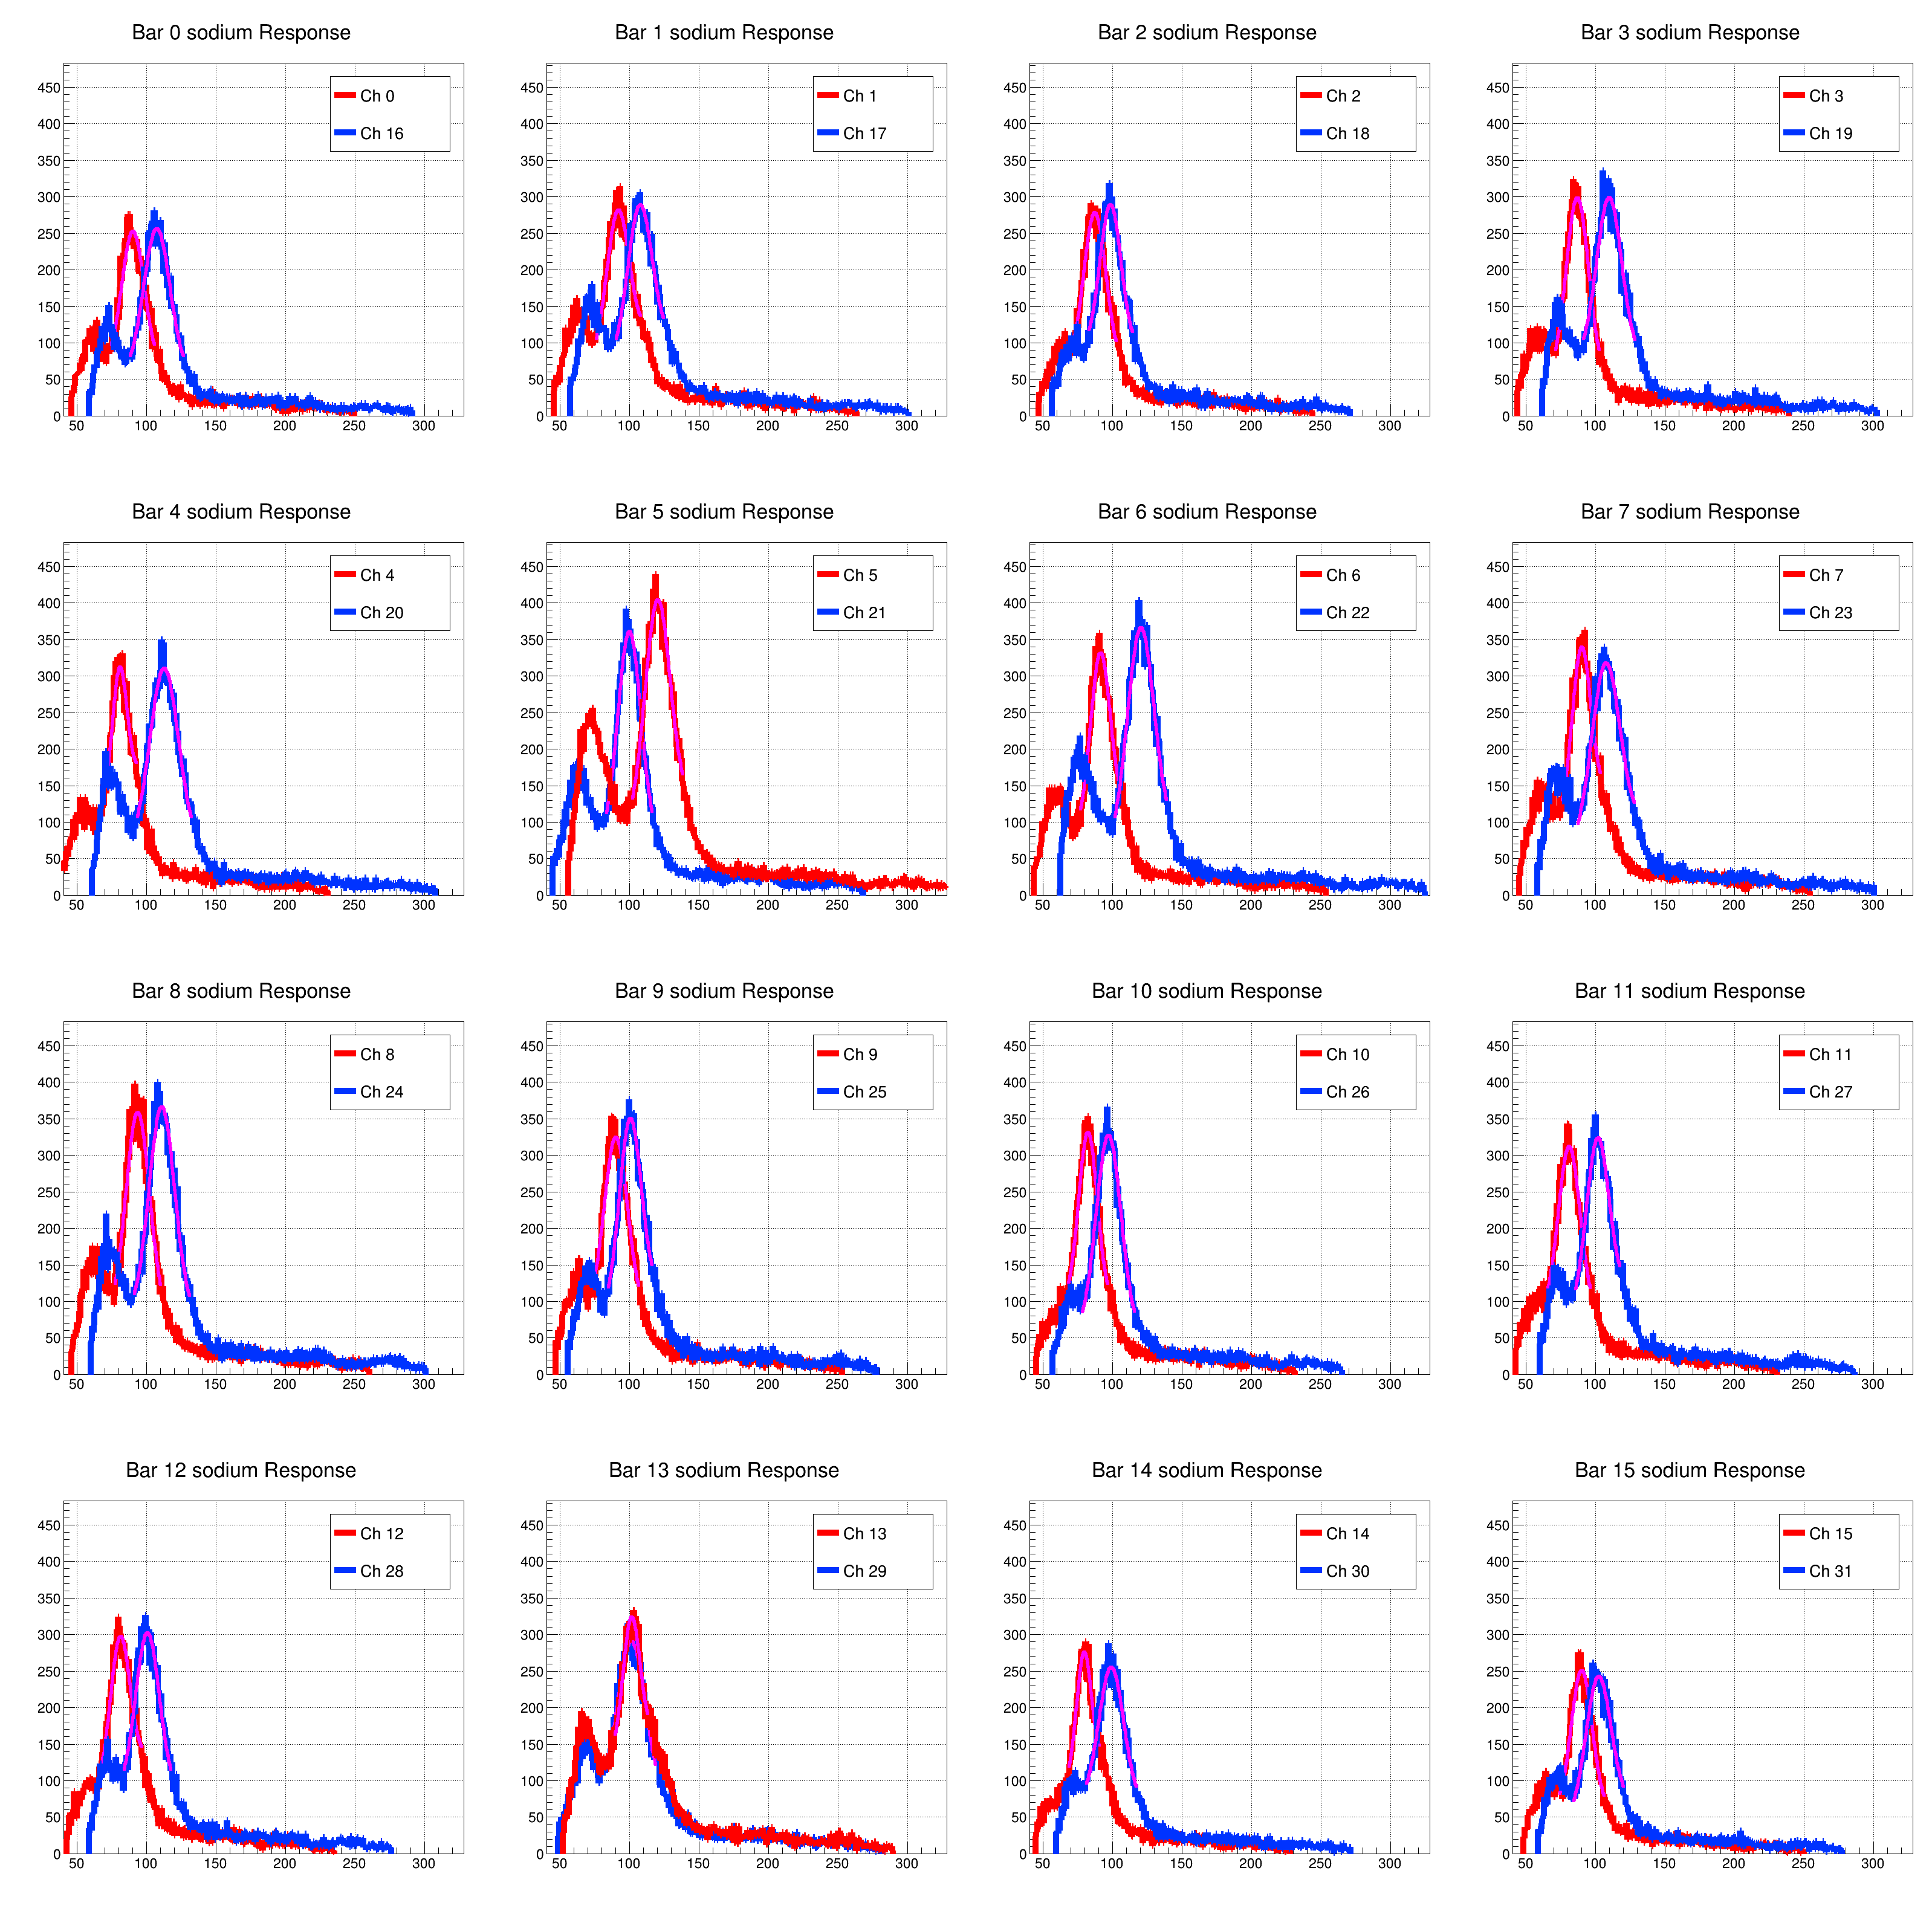

In [4]:
# Plot spectra for each module/bar

n_rows, n_cols = 4, 4
canvas = TCanvas('','',TPAD_WIDTH*n_cols,TPAD_HEIGHT*n_rows)
tlegend_coords = (0.7, 0.7, 0.97, 0.87)

def gaus(x, mu=0, sig=1):
    return 1/(sig*(2*math.pi)**0.5) * math.exp(-0.5*((x-mu)/sig)**2)

def fit_gamma(hist, pol=2):
    '''gaussian + polynomial background'''
    def bc(bin):
        return hist.GetBinCenter(bin)
    def bv(x):
        return hist.GetBinContent(hist.FindBin(x))

    old_chisq = hist.GetListOfFunctions()[-1].GetChisquare()
    # print(f', {old_chisq}',end='') # @FIT_X2
    NS = 2
    for i in range(3):
        if i == 0:
            # bin = 0;       underflow bin
            # bin = 1;       first bin with low-edge xlow INCLUDED
            # bin = nbins;   last bin with upper-edge xup EXCLUDED
            # bin = nbins+1; overflow bin
            centers = np.array([hist.GetBinCenter(ibin) for ibin in range(1, hist.GetNbinsX())])
            content = np.array([hist.GetBinContent(ibin) for ibin in range(1, hist.GetNbinsX())])
            A, mu = 0, 0
            for ic, (ce, co) in enumerate(zip(centers[::-1], content[::-1])):
                if ic < 10:
                    continue
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-5:ic+5]), np.mean(centers[::-1][ic-5:ic+5])
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-10:ic+10]), np.mean(centers[::-1][ic-10:ic+10])
                # if co_ave10 > A and co_ave10 > np.mean(content):
                #     mu, A = ce_ave10, co_ave10
                # if mu and co_ave10 < A*3/4:
                #     break
                left = np.mean(content[::-1][ic:ic+15])
                right = np.mean(content[::-1][ic-15:ic])
                center = np.mean(content[::-1][ic-5:ic+5])
                if center > left and center > right and center > np.mean(content) and abs(left-right)*2/(left+right) < 0.1:# and center > A:
                    mu, A = ce, co
                    # print(hist.GetName(), mu, A)
                    break
            # idx = np.argmax(content * (np.abs(centers-mu) < 10))
            # A, mu = content[idx], centers[idx]
            # A, mu = hist.GetMaximum(), bc(hist.GetMaximumBin())
            # A = hist.GetBinContent(int(mu))
            sig, p0, p1, p2 = 0, 0, 0, 0



        # print(f'{A=:.2f}, {mu=:.2f}, {sig=:.2f}, {p0=:.2f}, {p1=:.2f}')
        # aa = A*gaus(0)/2+p0+p1*(mu+sig*(2*math.log(2))**0.5)
        aa = A/2+p0+p1*(mu+sig*(2*math.log(2))**0.5)
        x_fwhm = bc(hist.FindLastBinAbove(aa))
        fwhm = abs((x_fwhm-mu)) * 2
        # fwhm = bc(hist.FindLastBinAbove(aa)) \
        #         - bc(hist.FindFirstBinAbove(aa,
        #                                     firstBin=hist.FindBin(mu - (1.5*(bc(hist.FindLastBinAbove(aa)) - mu))),
        #                                     lastBin=hist.GetMaximumBin()))
        sig = fwhm / (2*(2*math.log(2))**0.5)
        # if not sig:
        #     sig = mu**0.5

        # print(bv(mu),bv(mu-3*sig),bv(mu+3*sig))
        # A = gaus(0) * (bv(mu) - (bv(mu-NS*sig)+bv(mu+NS*sig))/2) / ( gaus(0) - gaus(NS) )
        A = gaus(0) * (bv(mu) - (bv(mu-NS*sig)+bv(mu+NS*sig))/2) / ( gaus(0) - gaus(NS) )
        # print(i)
        p1 = (bv(mu+NS*sig)-bv(mu-NS*sig)) / (2*NS*sig)
        p0 = bv(mu) - (A + p1*mu)
        # print(i, hist.GetName(), mu, sig, A, p0, p1)
        # print(f'{A=:.2f}, {mu=:.2f}, {sig=:.2f}, {p0=:.2f}, {p1=:.2f}')

        # hist.hh.GetListOfFunctions()[-1].SetParameter(0, A)
        # hist.hh.GetListOfFunctions()[-1].SetParameter(0, A)
    # print()

    # A *= gaus(0)
    for source in SOURCE_ENERGY_FIT_PAR_IDXS:
        if source in hist.GetName():
            eng = SOURCE_ENERGY_FIT_PAR_IDXS[source][0]
            mu /= eng
    # print(hist.GetListOfFunctions()[-1].GetFormula())
    # mu0 = hist.GetListOfFunctions()[-1].GetParameter(0)
    # sig0 = hist.GetListOfFunctions()[-1].GetParameter(1)
    # A0 = hist.GetListOfFunctions()[-1].GetParameter(2)
    # print(f'{hist.GetName()}')
    # print(f'{mu0=:.2f}, {mu=:.2f} | {(mu-mu0)/mu0=:.3f}')
    # print(f'{sig0=:.2f}, {sig=:.2f} | {(sig-sig0)/sig0=:.3f}')
    # print(f'{A0=:.2f}, {A=:.2f} | {(A-A0)/A0=:.3f}')
    # print()

    offset = 0 # also will need to fix
    fit_eq = f'[2]*exp(-0.5*(x-{offset}-[0]*{eng})**2/[1]**2) + [3] - [4]*x'# + [5]*x*x'

    # print(mu, sig, A, p0, p1)
    for i in range(3):
        xl, xh = mu*eng - NS*sig, mu*eng + NS*sig
        fit = TF1(f'{hist.GetName()}_fit{i}',fit_eq, xl, xh)
        fit.SetParLimits(0, mu*2/3, mu*4/3)
        fit.SetParLimits(1, sig*2/3, sig*4/3)
        fit.SetParLimits(2, A*2/3, A*4/3)
        # fit.SetParLimits(3, p0*2/3, p0*4/3)
        fit.SetParLimits(3, 0, p0*4/3)
        # fit.SetParLimits(4, p1*2/3, p1*4/3)
        fit.SetParLimits(4, 0, p1*4/3)

        fit.SetParameters(mu, sig, A, p0, p1)#, p2)
        # fit.SetParLimits(4, -1e999, 0)
        # fit.SetRange(xl, xh)
        hist.Fit(fit, 'QM0', '', xl, xh)
        hist.GetListOfFunctions()[-1] = fit
        mu = fit.GetParameter(0)
        sig = fit.GetParameter(1)
        A = fit.GetParameter(2)
        p0 = fit.GetParameter(3)
        p1 = fit.GetParameter(4)
        # p2 = fit.GetParameter(5)
        # print(mu*eng, sig, A, p0, p1)
    # print('\n\n')
    new_chisq = fit.GetChisquare()
    # print(f', {new_chisq}],') # @FIT_X2
    return mu, fit.GetParError(0), sig, A, p0, p1


for module in modules:
    for source in ('spe', module['source']):
        print(f'plotting {source} spectra for module {module["id"]}')
        canvas.Clear()
        canvas.Divide(n_cols, n_rows)
        tfile = module['tfile']

        ### Create Histos
        hists, legends, hmin, hmax, xmin, xmax = [], [], 1e99, -1, 1e99, -1
        for bar in BARS:
            chs = [bar, bar+16] # [left_ch, right_ch]
            nns = [f'Ch {ch}' for ch in chs]  # names
            hhs = [tfile.Get(f'{source}_ch{ch}') for ch in chs]  # histograms
            tts = [f'Bar {bar} {source} Response'] * len(chs)  # histogram titles
            lws = [10] * len(chs)  # histogram line widths
            lcs = [rt.kRed, rt.kAzure]  # histogram line colors

            # Make the legend for each subplot
            legend = TLegend(*tlegend_coords)
            legend.SetTextSize(TLEGEND_TEXT_SIZE)

            for ihh, hh in enumerate(hhs):
                if FIT_GAMMAS and source not in ('spe','lyso'):
                    # print(f'[{chs[ihh]}', end='') # @FIT_X2
                    mu, mue, sig, A, p0, p1 = fit_gamma(hh)
                    # print(mu, sig, A, p0, p1)
                    module['source_charge'][bar+ihh*16] = [
                        # A/gaus(0) / hh.Integral(),
                        mu*1000*ATTENUATION_FACTOR,
                        mue*1000*ATTENUATION_FACTOR
                        # sig*ATTENUATION_FACTOR/SOURCE_ENERGY_FIT_PAR_IDXS[source][0]
                    ]
                    # print(A, mu, sig, p0, p1)
                if len(hh.GetListOfFunctions()):
                    # draw the function it exists
                    hh.GetListOfFunctions()[-1].SetLineWidth(int(lws[ihh]/2))
                    hh.GetListOfFunctions()[-1].SetLineColor(rt.kMagenta)
                hh.SetTitle(tts[ihh])
                hh.SetName(nns[ihh])
                hh.GetXaxis().SetTitle('Charge (pC)')
                hh.SetLineColor(lcs[ihh])
                hh.SetLineWidth(lws[ihh])
                legend.AddEntry(hh, f'{nns[ihh]}', 'l')
                # update min and max if necessary
                hmin = 0 #min(hmin, hh.GetBinContent(hh.GetMinimumBin()))# hh.GetMinimum()) # hist max is set weird alreadyz
                hmax = max(hmax, hh.GetBinContent(hh.GetMaximumBin()))# hh.GetMaximum()) # hist max is set weird alreadyz
                xmin = min(xmin, hh.GetXaxis().GetXmin())
                xmax = max(xmax, hh.GetXaxis().GetXmax())

            hists.append(hhs)
            legends.append(legend)

        ### Set Axis Ranges
        hmin, hmax = 0, hmax*1.1#fix_yrange(hmin, hmax)  # add some paddings

        ### Draw
        for ihhs, (hhs, lg) in enumerate(zip(hists,legends)):
            canvas.cd(ihhs + 1).DrawFrame(xmin, hmin, xmax, hmax, hhs[0].GetTitle())
            canvas.cd(ihhs + 1).SetGrid()
            canvas.cd(ihhs + 1).SetRightMargin(0)
            hhs.sort(key=lambda h: h.GetXaxis().GetXmin()) # plot the hist with smaller charge first
            for hh in hhs:
                # hh.GetListOfFunctions()[-1].SetLimits(xmin, xmax)
                # hh.GetXaxis().SetRangeUser(xmin, xmax)
                # hh.SetMinimum(hmin)
                # hh.SetMaximum(hmax)
                hh.Draw('same')
            lg.Draw()

        canvas.Draw()
        sout = module['source'] + ('' if source == module['source'] else '_spe')
        canvas.Print(f'{PLOT_DIR}/module_{module["id"]}_{sout}_spectra.png')


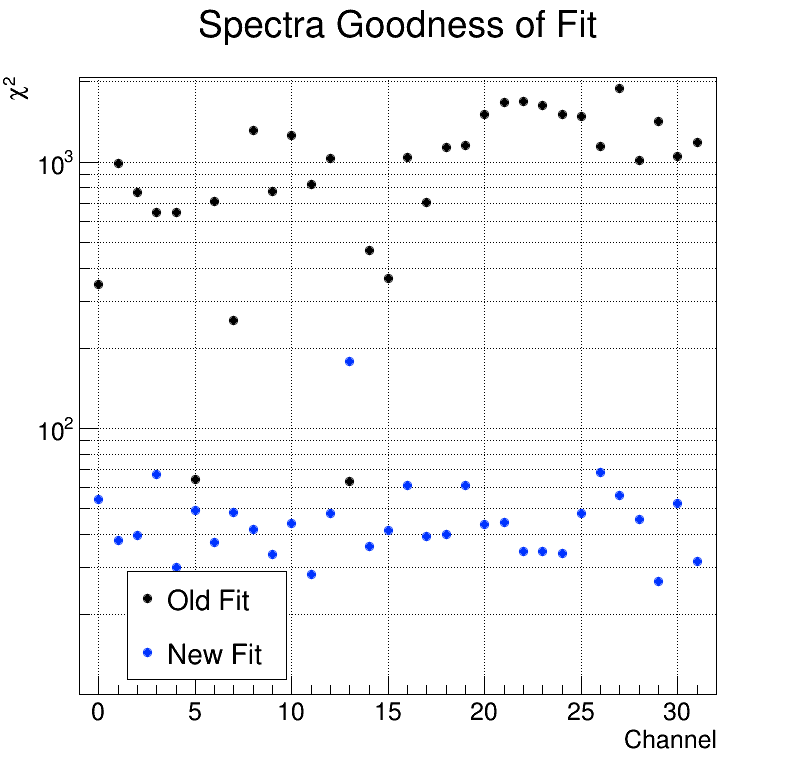

In [5]:
# fit comparision plot

#[channel, old chis quare, new chi square]
#this data for 3 sigma + pol1 bkg and is from run240117, sodium, module 200042
# print it to terminal using the spectra plots cell, relevant lines are tagged @FIT_X2
chisqs = [
    [0, 346.0035876573985, 54.32091940711619],
    [16, 1038.1892986450416, 61.25058104901214],
    [1, 990.8570408713127, 37.96654962979902],
    [17, 707.4424578004553, 39.2111682313248],
    [2, 770.6197074500061, 39.70054123634703],
    [18, 1137.6978680965117, 40.084710542528995],
    [3, 644.956287005765, 67.22313977776345],
    [19, 1153.1950391353027, 61.165698215869504],
    [4, 645.8549113058159, 30.1643361757939],
    [20, 1510.315573421035, 43.63457040369597],
    [5, 64.4356560100046, 49.136811156784276],
    [21, 1674.3432005383927, 44.508895006303185],
    [6, 708.6198828556543, 37.19590831737035],
    [22, 1682.4849442928278, 34.60285459132573],
    [7, 254.44675840366673, 48.44202970400681],
    [23, 1636.4099002935093, 34.54109010469696],
    [8, 1311.1293247792707, 41.84700999743533],
    [24, 1513.3974625510982, 33.9763365350333],
    [9, 772.0487609729837, 33.73211068205337],
    [25, 1477.0169333797096, 47.829838037962325],
    [10, 1254.29484815785, 43.955205308964],
    [26, 1142.8992720386495, 68.58833760707783],
    [11, 822.603761057893, 28.40542720826144],
    [27, 1892.9305409344163, 56.17847554555771],
    [12, 1031.648255095239, 47.910365020913936],
    [28, 1012.6806303403786, 45.320009415766016],
    [13, 63.00590068768433, 178.01070958951206],
    [29, 1420.5751189236576, 26.543505077731815],
    [14, 466.28031187214907, 36.1440551607208],
    [30, 1053.252217066116, 52.23013980813282],
    [15, 364.96742516071356, 41.29514745032394],
    [31, 1179.316706002021, 31.723616570610265],
]
chisqs.sort(key=lambda x: x[0])

#
canvas = TCanvas('','',TPAD_WIDTH,TPAD_HEIGHT)
tlegend_coords = (0.16, 0.12, 0.36, 0.26)
canvas.SetGrid()
# canvas.SetRightMargin(0.05)
canvas.SetLogy()


chs = np.array([x[0] for x in chisqs]) * 1.0
old_chisqs = np.array([x[1] for x in chisqs]) * 1.0
new_chisqs = np.array([x[2] for x in chisqs]) * 1.0

title = f'Spectra Goodness of Fit'
xlabel, ylabel = 'Channel', '#chi^{2}'
xrange, yrange = (-1, 32), (10, 1.1*np.max(chisqs))
lns = ['Old Fit', 'New Fit']
lws = [2,2]
lcs = [rt.kBlack, rt.kAzure]

# Plot
legend = TLegend(*tlegend_coords)
legend.SetTextSize(TLEGEND_TEXT_SIZE)

gr0 = TGraph(len(chs), chs, old_chisqs)
gr1 = TGraph(len(chs), chs, new_chisqs)
for igr, gr in enumerate([gr0, gr1]):
    gr.SetTitle(title)
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)
    gr.GetXaxis().SetLimits(*xrange)
    # gr.GetYaxis().SetLimits(*yrange)
    gr.SetMinimum(yrange[0])
    gr.SetMaximum(yrange[1])
    gr.SetName(lns[igr])
    gr.SetLineWidth(0)
    gr.SetLineWidth(lws[igr])
    gr.SetLineColor(lcs[igr])
    # gr.SetFillColorAlpha(lcs[igr], 0.3)
    gr.SetMarkerSize(lws[igr]/2)
    gr.SetMarkerColor(lcs[igr])
    gr.SetMarkerStyle(rt.kFullCircle)


    gr.Draw(('' if igr else 'A') + ' P')
    legend.AddEntry(gr, gr.GetName(), 'P')

legend.Draw()
canvas.Draw()


# Light Yield



plotting spe and sodium light yield for module 100026


/tmp/ipykernel_26466/210472345.py:22: RuntimeWarning: divide by zero encountered in divide
  ly_pe = ly_src / ly_spe
/tmp/ipykernel_26466/210472345.py:24: RuntimeWarning: invalid value encountered in divide
  ly_pe[:,1] = ly_pe[:,0] * sum([(ly[:,1]/ly[:,0])**2 for ly in (ly_spe,ly_src)])**0.5


plotting spe and cobalt light yield for module 200041


/home/psimmerl/.miniconda3/envs/pyroot/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


plotting spe and cesium light yield for module 100026
plotting spe and cesium light yield for module 200042
plotting spe and cobalt light yield for module 100026
plotting spe and sodium light yield for module 200042
plotting spe and cesium light yield for module 200041
plotting spe and cobalt light yield for module 200042
plotting spe and sodium light yield for module 200041


Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)
Error in <TGaxis::PaintAxis>: wmin (0.000000) == wmax (0.000000)


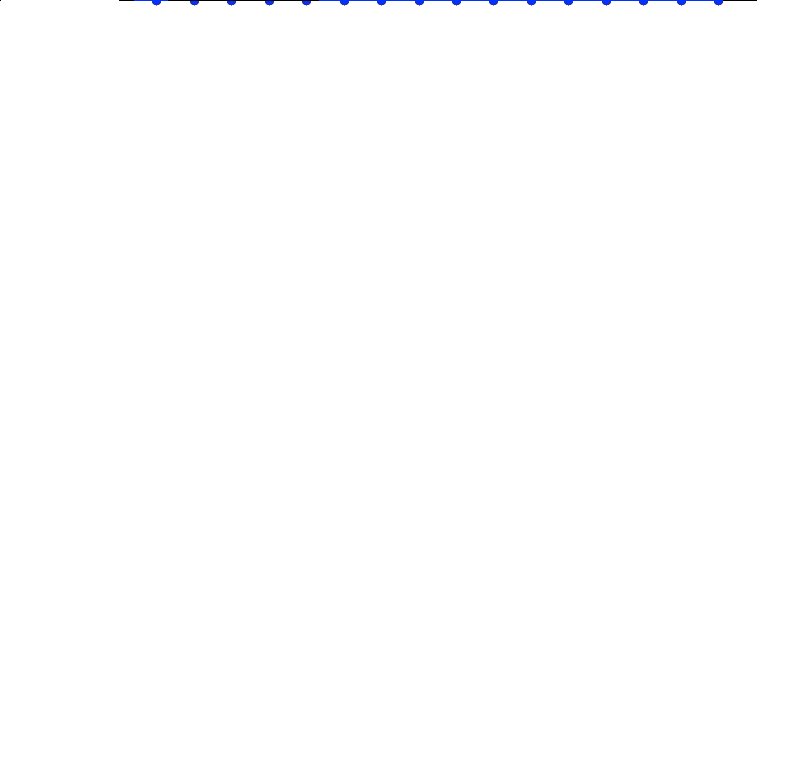

In [6]:
# Plot light yield for each module
canvas = TCanvas('','',TPAD_WIDTH,TPAD_HEIGHT)
tlegend_coords = (0.16, 0.895, 0.40, 0.74)

def tge_ly(ly):
    lyL, lyR = ly[:16], ly[16:]
    lyA = (lyL + lyR) / 2
    lyA[:,1] = np.sqrt( (lyL**2 + lyR**2)[:,1] ) / 2
    return [TGraphErrors(len(BARS),BARS*1.0,ly[:,0]*1.0,BARS*0.0,ly[:,1]*1.0) for ly in (lyL, lyA, lyR)]

linearity = []

for imd, module in enumerate(modules):
    print(f'plotting spe and {source} light yield for module {module["id"]}')
    ### load module info
    mid, vov, vtt, source, tfile = (module[x] for x in ('id', 'vov', 'vtt', 'source', 'tfile'))
    # spe charge is pC(/SPE), source charge is pC/MeV
    ly_spe, ly_src = module['spe_charge'], module['source_charge'] # 32 channels x (value, errror)

    # calculate photoelectrons created by source
    # Light Yield [PE / MeV] = Source Yield [ pC / MeV ] / Single Photoelectron Yield [ pC / PE ]
    ly_pe = ly_src / ly_spe
    # ly_pe[:,1] = ly_pe[:,0] * ( (ly_spe[:,1]/ly_spe[:,0])**2 + (ly_src[:,1]/ly_src[:,0])**2 )**0.5
    ly_pe[:,1] = ly_pe[:,0] * sum([(ly[:,1]/ly[:,0])**2 for ly in (ly_spe,ly_src)])**0.5

    linearity.append([
        module['id'],
        source,
        np.mean(ly_pe[:,0][np.isfinite(ly_pe[:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:,1][np.isfinite(ly_pe[:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,0][np.isfinite(ly_pe[:16,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,1][np.isfinite(ly_pe[:16,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,0][np.isfinite(ly_pe[16:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,1][np.isfinite(ly_pe[16:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
    ])

    ### Create Graphs
    lys = [[ly[:16],(ly[:16]+ly[16:])/2,ly[16:]] for ly in [ly_spe, ly_src, ly_pe]]
    graphs = [ tge_ly(ly) for ly in  [ly_spe, ly_src, ly_pe]]

    tt = f' Yield (Module {mid}, V_{{OV}}={vov}V, V_{{TT}}={vtt}mV)'
    titles = [ ss+tt for ss in ('SPE', f'{source.title()} Charge', f'{source.title()} Light') ]
    xlabels = ['Bar', 'Bar', 'Bar'] # x-labels
    ylabels = ['Charge Yield [pC]', 'Charge Yield [pC / MeV]', 'Light Yield [PE / MeV]'] # y-labels
    xranges = [ (-1, 16) for ly in (ly_spe, ly_src, ly_pe) ]
    yranges = [ fix_yrange(0, np.max(ly[:,0])*1.5) for ly in (ly_spe, ly_src, ly_pe) ]

    lns = ['Left (A)', 'Average', 'Right (B)'] # line names
    lws = [2,2,2] # line widths
    lcs = [rt.kRed, rt.kBlack, rt.kAzure] # line colors
    # lls = [ [f'average yield = {ly.mean():.0f} #pm {ly.std():.2f} (#pm {100*ly.std()/ly.mean():.0f}%)' for ly in [lys[:16,0],lys[16:,0],(lys[:16,0]+lys[16:,0])/2]] for lys in (ly_spe, ly_src, ly_pe) ]


    # plot
    for igrs, grs in enumerate(graphs):
        canvas.Clear()
        canvas.SetGrid()
        canvas.SetRightMargin(0.05)
        canvas.SetLeftMargin(0.15)

        legend = TLegend(*tlegend_coords)
        legend.SetTextSize(TLEGEND_TEXT_SIZE)
        latex = TLatex()
        latex.SetTextAlign(11)
        latex.SetTextSize(0.04)

        for igr, gr in enumerate(grs):
            gr.SetTitle(titles[igrs])
            gr.GetXaxis().SetTitle(xlabels[igrs])
            gr.GetYaxis().SetTitle(ylabels[igrs])
            gr.GetXaxis().SetLimits(*xranges[igrs])
            gr.SetMinimum(yranges[igrs][0])
            gr.SetMaximum(yranges[igrs][1])

            gr.SetName(lns[igr])
            gr.SetLineWidth(0)
            gr.SetLineWidth(lws[igr])
            gr.SetLineColor(lcs[igr])
            # gr.SetFillColorAlpha(lcs[igr], 0.3)
            gr.SetMarkerSize(lws[igr]/2)
            gr.SetMarkerColor(lcs[igr])
            gr.SetMarkerStyle(rt.kFullCircle)
            rt.gStyle.SetEndErrorSize((lws[igr]*3)//2)

            gr.Draw(('' if igr else 'A') + ' LPE')
            legend.AddEntry(gr, gr.GetName(), 'LP')

            latex.SetTextColor(lcs[igr])

            ly = lys[igrs][igr][:,0]
            # print(lys[igrs][igr][:,0].mean())
            # print(lys[igrs][igr][:,1].mean())
            # fit1 = TF1('fit1', 'pol0')
            # gr.Fit('fit1', 'QEN')
            # a, e = fit1.GetParameter(0), fit1.GetParError(0)
            # a, e = _ly.mean(), ((_lyE**2).sum()**0.5)/len(_ly)
            a, e = ly.mean(), ly.std()
            # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'yield: mean={a:.0f}, rmse={e:.1f}, mae={100*np.abs((ly-a)).mean()/a:.1f}%')
            if a < 10:
                latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.1f}, rmse={100*e/a:>4.1f}%')
            else:
                latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.0f}, rmse={100*e/a:>4.1f}%')
            # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'average light yield: {a:.0f} #pm {e:.2f} ({100*e/a:.0f}%)')


        legend.Draw()
        canvas.Draw()
        canvas.Print(f'{PLOT_DIR}/module_{mid}_{"_".join(titles[igrs].split(" ")[:2]).lower()}_yield.png')

        gc.extend(grs)


0 [[2745.8917495    20.02553044]
 [2046.0543987    75.24521025]
 [1791.97938222   13.89617642]] [[2560.07931431   25.66295558]
 [2120.99797095  145.37774046]
 [2099.24081317   13.44110197]] [[2931.70418468   14.38810529]
 [1980.47877298   13.87924631]
 [1484.71795127   14.35125086]]
1 [[2121.02350158   11.19967701]
 [1720.58355552   30.14544562]
 [1387.00038603    8.97451219]] [[1976.10833342   13.95234471]
 [1808.20426032   52.75301687]
 [1620.23823206    9.40721123]] [[2265.93866975    8.44700931]
 [1632.96285072    7.53787438]
 [1153.76254       8.54181316]]
2 [[38565.42376943   420.34995662]
 [29582.32501076   675.45529487]
 [24623.73535457   196.62172001]] [[35772.6754423    386.02469226]
 [30884.2671861   1157.0790773 ]
 [28199.34819542   230.11082259]] [[40834.53178522   448.23923392]
 [28367.17898044   225.93976459]
 [21048.12251372   163.13261743]]


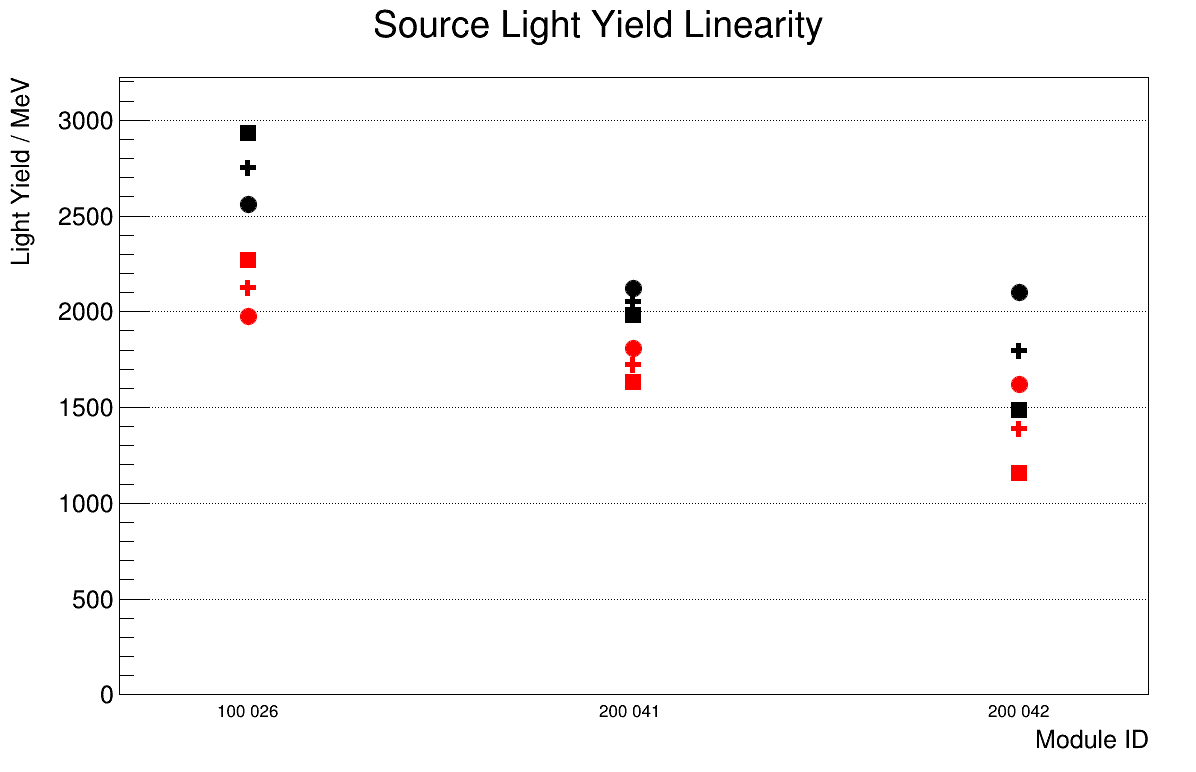

In [7]:
canvas = TCanvas('','',int(1.5*TPAD_WIDTH),TPAD_HEIGHT)
canvas.SetGrid()
canvas.SetRightMargin(0.04)
# color by source
# location by module ID
linearity = sorted(linearity, key=lambda x: x[0])

aves = [[[l[2] / SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000, l[3]/ SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000] for l in linearity if l[1] == source] for source in SOURCES[1:]]
lefts = [[[l[4] / SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000, l[5]/ SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000] for l in linearity if l[1] == source] for source in SOURCES[1:]]
rights = [[[l[6] / SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000, l[7]/ SOURCE_ENERGY_FIT_PAR_IDXS[l[1]][0] * 1000] for l in linearity if l[1] == source] for source in SOURCES[1:]]

for igr in range(len(aves)): # loop through sources
    vas, vls, vrs = np.array(aves[igr]), np.array(lefts[igr]), np.array(rights[igr])
    vas[~np.isfinite(vas)], vls[~np.isfinite(vls)], vrs[~np.isfinite(vrs)] = 0, 0, 0

    print(igr,vas,vls,vrs)
    # if igr == 0:
    #     vas = vas[:2]
    #     vls = vls[:2]
    gra = TGraphErrors(len(vas),np.arange(len(vas))*1.,vas[:,0]*1.,vas[:,1]*0.,vas[:,1]*1.)
    grl = TGraphErrors(len(vls),np.arange(len(vls))*1.,vls[:,0]*1.,vls[:,1]*0.,vls[:,1]*1.)
    grr = TGraphErrors(len(vrs),np.arange(len(vrs))*1.,vrs[:,0]*1.,vrs[:,1]*0.,vrs[:,1]*1.)

    for igr2, gr in enumerate([grl,grr,gra]):
        gr.SetTitle('Source Light Yield Linearity')
        gr.GetXaxis().SetTitle('Module ID')
        gr.GetYaxis().SetTitle('Light Yield / MeV')
        gr.GetXaxis().SetLimits(-1/len(vrs), len(vrs)-1+1/len(vrs))
        gr.SetMinimum(0)
        gr.SetMaximum(np.max(np.r_[vas,vls,vrs])*1.1)
        gr.SetLineWidth(0)#2)
        gr.SetLineColor(STD_COLOR_LIST[igr])
        gr.SetMarkerSize(2)
        gr.SetMarkerColor(STD_COLOR_LIST[igr])
        gr.SetMarkerStyle([rt.kFullCircle,rt.kFullSquare,rt.kFullCross][igr2])
        gr.GetXaxis().SetBinLabel(gr.GetXaxis().FindBin(0), '100 026')
        gr.GetXaxis().SetBinLabel(gr.GetXaxis().FindBin(1), '200 041')
        gr.GetXaxis().SetBinLabel(gr.GetXaxis().FindBin(2), '200 042')
        gr.GetXaxis().LabelsOption('h')

        gr.Draw(('' if igr+igr2 else 'A')+' P')
    
    gc.extend([gra, grl, grr])

canvas.Draw()
